### Modeling

In [1]:
# minist dataset: http://yann.lecun.com/exdb/mnist/

from torchvision.datasets import MNIST
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


%matplotlib inline

In [2]:
train = MNIST("./data/", train=True, download=True) #60000
test= MNIST("./data/",train=False, download=True) #10000

label:  4
size:  (28, 28)
max pixle value:  255


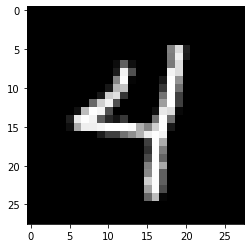

In [3]:
# show random train sample
num = np.random.randint(len(train))

plt.imshow(train[num][0], cmap='gray')
print("label: ", train[num][1])

print("size: ", train[num][0].size)

print("max pixle value: ", np.max(train[num][0]))

In [4]:
# define net

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #layers
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
    
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        # forward process
#         print("input shape: ", x.shape)
        x = self.conv1(x)
#         print("conv1 output shape: ", x.shape)
        x = F.relu(x)
        
        x = self.conv2(x)
#         print("conv2 output shape: ", x.shape)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
#         print("max_pool2d output shape: ", x.shape)
        # checking
        x = self.dropout1(x)
        x = torch.flatten(x,1)
#         print("flatten output shape: ", x.shape)
        x = self.fc1(x)
#         print("fc1 output shape: ", x.shape)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
#         print("fc2 output shape: ", x.shape)
        
        output  = F.log_softmax(x, dim=1)
        return output

In [5]:
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [6]:
random_data = torch.rand((1, 1, 28, 28))

result = net(random_data)
print(result)

tensor([[-2.2649, -2.3313, -2.2577, -2.3544, -2.2555, -2.2764, -2.3034, -2.2957,
         -2.3005, -2.3953]], grad_fn=<LogSoftmaxBackward>)


input shape:  torch.Size([1, 1, 28, 28])

conv1 output shape:  torch.Size([1, 32, 26, 26])

conv2 output shape:  torch.Size([1, 64, 24, 24])

max_pool2d output shape:  torch.Size([1, 64, 12, 12])

flatten output shape:  torch.Size([1, 9216])

fc1 output shape:  torch.Size([1, 128])

fc2 output shape:  torch.Size([1, 10])

tensor([[-2.2794, -2.2405, -2.3110, -2.2513, -2.3883, -2.2817, -2.3586, -2.2711,
         -2.4489, -2.2183]], grad_fn=<LogSoftmaxBackward>)


### param of Conv2d
(height, width)
* stride： 卷积核移动步长
* padding： padding size
* dilation: 感受野散开程度 （[可视化](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md)）
* groups: 分组卷积 ([Blog](https://www.cnblogs.com/shine-lee/p/10243114.html))
* padding_mode: padding模式([Blog](https://blog.csdn.net/hyk_1996/article/details/94447302))

### param of MaxPool2d
(height, width)
* stride： 卷积核移动步长, 默认None, 即和kernel_size相同
* padding： padding size
* dilation: 感受野散开程度 （[可视化](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md)）

卷积/池化输出尺寸:
```python
import math

in_w, in_h =28, 28

pad_h, pad_w = 0, 0
dil_h, dil_w = 1, 1 # default is 1
s_h, s_w = 1, 1 # default is 0
k_h, k_w = 3, 3

#output featuremap size height
out_h = math.floor( (in_h + 2*pad_h - dil_h*(k_h-1) - 1)/s_h + 1)
#output featuremap size width
out_w = math.floor( (in_w + 2*pad_w - dil_w*(k_w-1) - 1)/s_w + 1)
print(out_h)
print(out_w)
```


In [7]:
# define loss function and optimize function

import torch.optim as optim


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum=0.9)


In [8]:
# define dataloader
# since we are using MNIST from torchvision, no need for "class Dataset()"

# transforms

#PIL Image Transform
class Rescale():
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple)),"output_size not int or tuple"
        self.output_size = output_size
    def __call__(self, sample):
        image = sample
        if isinstance(self.output_size, int):
            new_h = new_w = self.output_size
        else:
            new_h, new_w = self.output_size
        image = image.resize((new_w, new_h))

        return image

class Normalize():
    def __init__(self, max_pixle):
        self.max_pixle = max_pixle
    def __call__(self, sample):
        image = sample
        image = np.array(image)/self.max_pixle
        
        return image
class ToTensor():
    def __call__(self, sample):
        image = sample
        image = np.expand_dims(image,2)
        # H,W,C ==> C,H,W
        image = image.transpose((2,0,1))
        
        image = torch.from_numpy(image).type(torch.FloatTensor)
        
        return image
        
# Label Transform
class LabelTransform():
    def __call__(self, label):
        label_arr = np.zeros(10, dtype=int)
        label_arr[label] = 1
        label = torch.from_numpy(label_arr)
#         label = torch.from_numpy(np.array([int(label)]))
        return label

# dataloader
from torchvision import transforms
from torch.utils.data import DataLoader
compose = transforms.Compose([Rescale(28),Normalize(255),ToTensor()])

train = MNIST("./data/", train=True, \
              download=True, transform=compose, \
#              target_transform=LabelTransform()\
             ) 
test = MNIST("./data/", train=False, \
              download=True, transform=compose, \
#              target_transform=LabelTransform()\
            ) 
trainloader = DataLoader(train, batch_size = 8, shuffle=True, num_workers=4)
testloader = DataLoader(test, batch_size = 8, shuffle =True, num_workers=4)

In [9]:
# inspect one mini-batch
next(iter(trainloader))[1]

tensor([7, 1, 8, 7, 8, 3, 3, 5])

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [11]:
net = net.to(device)

In [12]:
# training 

for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.type(torch.FloatTensor).to(device)
        labels = labels.to(device)
#         labels = labels.type(torch.FloatTensor).to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
#         print(outputs.shape)
#         print(labels.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

[1,  2000] loss: 0.742
[1,  4000] loss: 0.350
[1,  6000] loss: 0.258
[2,  2000] loss: 0.158
[2,  4000] loss: 0.142
[2,  6000] loss: 0.130


In [13]:
PATH = './pytorch_convNet.pth'
torch.save(net.state_dict(), PATH)

label:  4
size:  (28, 28)
max pixle value:  255


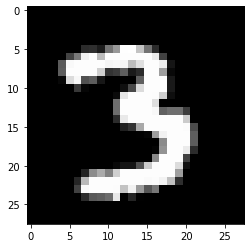

In [14]:
train = MNIST("./data/", train=True, download=True) #60000
test= MNIST("./data/",train=False, download=True) #10000

# show random train sample

plt.imshow(test[500][0], cmap='gray')
print("label: ", train[num][1])

print("size: ", train[num][0].size)

print("max pixle value: ", np.max(train[num][0]))

In [15]:
img = compose(test[500][0]).unsqueeze(0).to(device)
ouputs = net(img)

In [16]:
_, pred = torch.max(ouputs,1)

In [17]:
print(_,pred)

tensor([-1.4663e-05], device='cuda:0', grad_fn=<MaxBackward0>) tensor([3], device='cuda:0')


### Export to ONNX

In [23]:
import torch.onnx

In [24]:
net

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [30]:
dummy_input = torch.randn(1, 1, 28, 28).to(device)

torch.onnx.export(net, dummy_input, "pytorch_convNet.onnx",\
                  input_names =["input"],\
                  output_names = ["output"],\
                  keep_initializers_as_inputs = True
                 )

In [31]:
import onnx
import onnx.utils


model = onnx.load('pytorch_convNet.onnx')
polished_model = onnx.utils.polish_model(model)
onnx.save(polished_model, "pytorch_convNet-polished.onnx")

### ONNX Graph

In [32]:
import onnx


model = onnx.load("pytorch_convNet.onnx")
model = onnx.shape_inference.infer_shapes(model)
model_graph = model.graph


In [33]:
for t in model_graph.initializer:
    print(t)
    break

dims: 32
data_type: 1
name: "conv1.bias"
raw_data: "\'\311\211>p\364\333>\211\336\333=\3737\215\275\335\177\020\276^\323\256<\034\3618\274A\233Z\274\226\223\214\273\370\312\341\275+Q6\273\357\236\355\275\307P\010\276\266w\224\276\342\030\364>\0345\277=5\370\206=\354y!\275\262y\227>c\261\212\272y}\307\270\255k\010>i\252Z\276s\311\016>\014X^\275B\375\r\276\2049\245>\374\256\313>\000+\220\274(\361\252\276\367\274\241\276\245`K\276"

